<a href="https://colab.research.google.com/github/kimdesok/Text-classification/blob/main/Spam_Classification_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install autoviz

## LSTM to Detect Spams

In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Layers
from tensorflow.keras.layers import Bidirectional, Embedding, LSTM, Dense, Dropout

<h2>Loading Data</h2>

In [6]:
FILE_PATH = r"/content/spam.csv"
#FILE_PATH = r"/home/ubuntu/Kaggle2/Data/spam.csv"
df = pd.read_csv(FILE_PATH, encoding = 'latin-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [7]:
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']) # Removing empty columns 
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


<h2>Visualizing Data</h2>

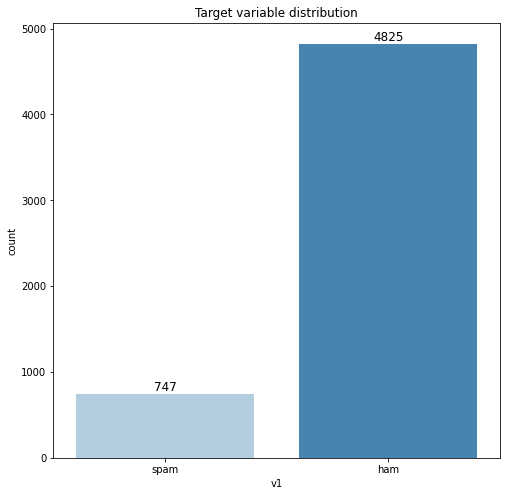

In [8]:
# Plotting a class distribution barplot
class_distribution = df['v1'].value_counts().sort_index(ascending = False)
plt.figure(figsize=(8,8))
ax = sns.countplot(x='v1', data=df, order = class_distribution.index, palette="Blues")
for i in ax.containers:
    ax.bar_label(i, label_type = 'edge', fontsize = 12)
plt.title('Target variable distribution')
plt.show()

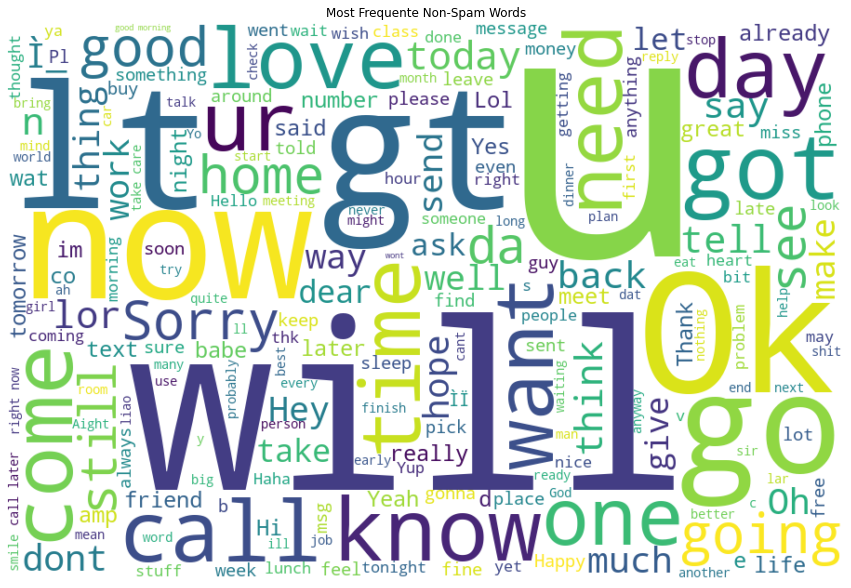

In [9]:
# Plotting word cloud for ham messages
ham = " ".join(df[df['v1'] == 'ham']['v2'])
wordcloud = WordCloud(width = 900, height = 600, max_words = 200, background_color ='white').generate(ham)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Most Frequente Non-Spam Words")
plt.show()

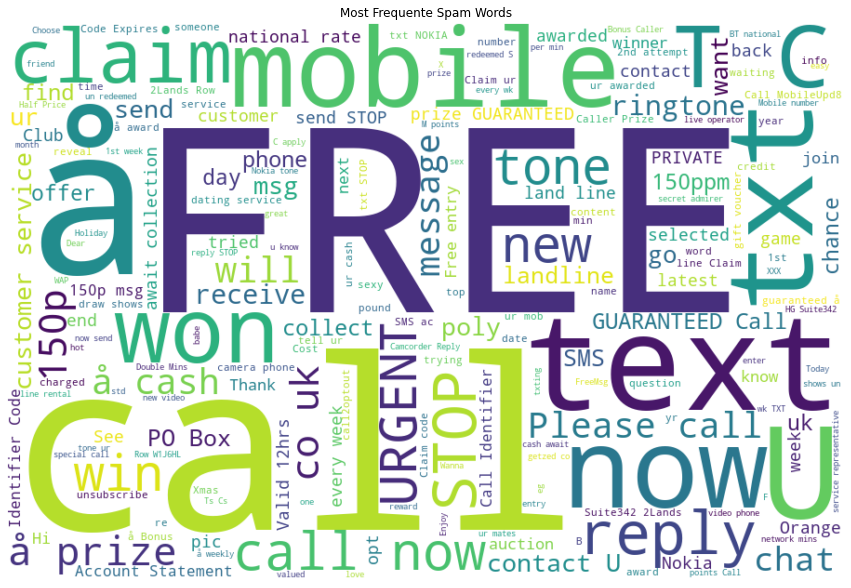

In [10]:
# Plotting word cloud form spam messages 
spam = " ".join(df[df['v1'] == 'spam']['v2'])
wordcloud = WordCloud(width = 900, height = 600, max_words = 200, background_color ='white').generate(spam)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Most Frequente Spam Words")
plt.show()

In [11]:
# Printing examples of ham messages
print("Ham texts:")
print(df[df['v1'] == 'ham']['v2'].head())

Ham texts:
0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
6    Even my brother is not like to speak with me. ...
Name: v2, dtype: object


In [12]:
# Printing examples of Spam messages 
print("Spams:")
print(df[df['v1'] == 'spam']['v2'].head())

Spams:
2     Free entry in 2 a wkly comp to win FA Cup fina...
5     FreeMsg Hey there darling it's been 3 week's n...
8     WINNER!! As a valued network customer you have...
9     Had your mobile 11 months or more? U R entitle...
11    SIX chances to win CASH! From 100 to 20,000 po...
Name: v2, dtype: object


<h2>Data Preprocessing</h2>

Data preprocessing is an essential step in any machine learning project, and it is especially important in projects containing text data. 

>* Data preprocessing for text data include several steps, such as cleaning, tokenizing, and vectorizing the text.
>* Cleaning the text is the first step in the preprocessing process. 
>* This involves removing any special characters, punctuation, and stopwords, as well as converting the text to lowercase. 
>* This helps to standardize the text and make it easier for the model to process. 
>* Additionally, regular expressions (re) can be used to remove any unwanted patterns in the text such as email addresses, phone numbers or URLs.

In [13]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

# Creating a function to clean text data
def text_cleaning(text):
    # Removing punctuation 
    text = re.sub(r'[^\w\s]', '', text)
    # Converting text to lowercase
    text = text.lower()
    # Removing digits
    text = re.sub(r'\d+','',text)
    # Removing stopwords that are common in the English language
    stop = stopwords.words('english')
    text = " ".join([word for word in text.split() if word not in stop])
    # Lemmatizing text
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    # Removing white spaces
    text = text.strip()
    
    return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [14]:
# Splitting training and testing sets
X_train, X_test, y_train,y_test = train_test_split(df['v2'], df['v1'], test_size = 0.3, random_state = 123)

# Applying text_cleaning function
X_train = X_train.apply(text_cleaning)
X_test = X_test.apply(text_cleaning)

In [15]:
# Displaying text after cleansing 
X_train

2156    hey cutie go wale kinda ok like hill shit stil...
3695                                      tirupur call da
4077                          gam gone outstanding inning
673     ditto wont worry saying anything anymore like ...
2659                                                   ok
                              ...                        
5218                     accidentally brought em home box
4060    aight ive set free think could text blake addr...
1346    ok stay night xavier sleeping bag im getting t...
3454    need lar jus testing e phone card dunno networ...
3582                         sent maga money yesterday oh
Name: v2, Length: 3900, dtype: object

## Tokenization
>* Since neural networks can only process numerical data, tokenization is done to convert text into numerical representations, while padding is applied to ensure that all input samples have the same length

In [16]:
# Data tokenization and padding 
max_length = max([len(i) for i in X_train])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_length)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length)

## Class imbalancing fixed

>* Next step is to use SMOTE to address the class imbalance in the dataset. SMOTE is an oversampling technique that is commonly used to balance imbalanced datasets.<br>

>* The way SMOTE works is by creating synthetic examples of the minority class by interpolating between existing minority class examples. This allows the algorithm to generate new examples of the minority class without having to collect more data. By oversampling the minority class, SMOTE helps to balance the dataset and enhance detection performance.

In [17]:
# Fixing class imbalance with SMOTE
smote = SMOTE(random_state = 42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [18]:
# Counting values after SMOTE
y_train.value_counts()

ham     3368
spam    3368
Name: v1, dtype: int64

In [19]:
print(X_train[:5])

[[   0    0    0 ...   34 1924 1925]
 [   0    0    0 ... 1501    2   44]
 [   0    0    0 ...  564 1926 1927]
 [   0    0    0 ...   21   19 1928]
 [   0    0    0 ...    0    0   13]]


We now have the same ammount of spam and ham messages.

Next step is to use LabelEncoder to encode the target variable, since neural network models can only process numerical data.

In [20]:
# Encoding target variable 
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

<h2>Creating a LSTM Model</h2>

Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) that is particularly well-suited for handling sequential data, such as text data. It is designed to remember the context of the previous data points and use that information to process the current data point. This makes LSTM particularly useful for text classification tasks, such as spam detection, where the meaning of a word can depend on the context of the surrounding words.

In [21]:
# Defining model structure
model = Sequential()
# Adding embedding layer to convert input data into a dense vector representation
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim =30, input_length = max_length))
# Adding LSTM layers 
model.add(LSTM(units=32, return_sequences = True))
model.add(LSTM(units=32))
# Adding a Dense Layer
model.add(Dense(units=32, activation = 'relu'))
model.add(Dense(units=8, activation = 'relu'))
# Adding a Dropout layer, in order to prevent overfitting
model.add(Dropout(rate=0.4))
# Adding an output Dense layer
model.add(Dense(units=1, activation = 'sigmoid'))
model

In [22]:
# Visualizing model structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 419, 30)           194880    
                                                                 
 lstm (LSTM)                 (None, 419, 32)           8064      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9

In [23]:
# Defining an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience = 24)

In [24]:
import tensorflow as tf
print(tf.__version__)
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
#print(gpus)
tf.debugging.set_log_device_placement(True)

#tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
#tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

2.11.0


In [25]:
# Compiling model
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics = ['accuracy'])

# Fitting model
history = model.fit(X_train, y_train, epochs = 200, batch_size = 16, validation_split = 0.2, callbacks =[early_stopping])

Epoch 1/200
337/337 [==============================] - 37s 79ms/step - loss: 0.6906 - accuracy: 0.5917 - val_loss: 0.7040 - val_accuracy: 0.0000e+00
Epoch 2/200
337/337 [==============================] - 12s 37ms/step - loss: 0.6832 - accuracy: 0.5913 - val_loss: 0.7289 - val_accuracy: 0.0000e+00
Epoch 3/200
337/337 [==============================] - 11s 32ms/step - loss: 0.6601 - accuracy: 0.5978 - val_loss: 0.8436 - val_accuracy: 0.0000e+00
Epoch 4/200
337/337 [==============================] - 11s 32ms/step - loss: 0.6377 - accuracy: 0.5976 - val_loss: 0.8873 - val_accuracy: 0.0000e+00
Epoch 5/200
337/337 [==============================] - 11s 31ms/step - loss: 0.6260 - accuracy: 0.5993 - val_loss: 0.8803 - val_accuracy: 0.0000e+00
Epoch 6/200
337/337 [==============================] - 11s 31ms/step - loss: 0.6114 - accuracy: 0.6037 - val_loss: 0.8893 - val_accuracy: 0.0000e+00
Epoch 7/200
337/337 [==============================] - 10s 29ms/step - loss: 0.5973 - accuracy: 0.6206 - v

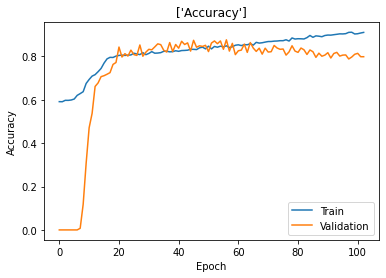

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(['Accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='lower right')
plt.show()

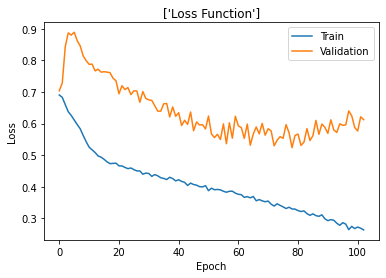

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(['Loss Function'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

The model seems to be performing well on the training set but not so well on the validation set, which is an indication of overfitting.<br><br>
We can try it out on our testing set to check its performance.

In [28]:
# Running model on testing set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

53/53 [==============================] - 2s 16ms/step


Accuracy: 0.9461722488038278
Precision: 0.7358490566037735
Recall: 0.9069767441860465
F1 Score: 0.8124999999999999


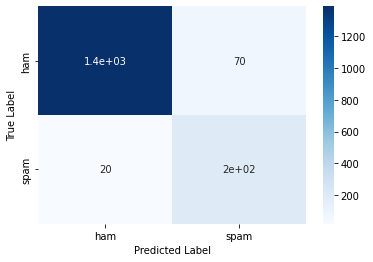

In [29]:
# Printing metric scores
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Plotting a confusion matrix
cm = confusion_matrix(y_test, y_pred).astype(int)
sns.heatmap(cm, annot=True, cmap='Blues',
xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [30]:
# Counting total values for ham messages (0) and spam messages (1) on testing set
from numpy import unique
value_counts = dict(zip(*np.unique(y_test, return_counts=True)))
print(value_counts)

{0: 1457, 1: 215}


In [31]:
# Printing accuracy on testing set
correct = np.count_nonzero(y_pred == y_test)
wrong = np.count_nonzero(y_pred != y_test)

print("The model predicted correctly",correct,"messages")
print("The model predicted incorrectly",wrong,"messages")

The model predicted correctly 2106974 messages
The model predicted incorrectly 688610 messages


<h2>Conclusion</h2>

Based on the results on the testing set, it seems that the model performed quite well in terms of spam detection. The model correctly detected 270 spam messages out of 288, and correctly flagged 2,146 messages as either spam or ham, with only 83 messages being flagged incorrectly.<br><br>

However, it's worth noting that the model performed poorly on the validation data, which could be an indication of overfitting. This means that the model was able to fit well to the training data but struggled to generalize to new unseen data.<br><br>

To enhance performance of this model, and other similar models, several steps could be taken, such as:<br><br>

- The use of techniques to prevent overfitting such as regularization, dropout, and early stopping;<br>
- The use of more diverse data for training and validation;<br>
- The use of more advanced architectures such as convolutional neural networks (CNNs) or transformer-based models;<br>
- The use of pre-trained embeddings such as word2vec or GloVe, which have been trained on large amounts of text data and can provide better representation of the data;<br>
- The use of more advanced techniques for data preprocessing such as BERT or GPT-2 for tokenization and embeddings.<br><br>

It's also worth mentioning that, in this specific project, the data was imbalanced, with only 8.7% of texts  being spam. This could also have affected the model's performance on the validation set. Using techniques of data augmentation could help the model to generalize better.<br><br>

In conclusion, this project has achieved good results in terms of spam detection, but the performance on validation set could be improved. To enhance the performance of this project, or other similar projects, it is recommended to use techniques to prevent overfitting, use more diverse data, use more advanced architectures, and use pre-trained embeddings.

Thank you for reading!<br><br>
<i>Luís Fernando Torres</i><br><br>
<a href="https://www.linkedin.com/in/luuisotorres/">LinkedIn</a>